In [88]:
# imports
import os
import cv2
import types
import numpy as np
import pandas as pd
import keras
from scipy import interp
from IPython.display import Image
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image as pilimg
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.applications.vgg16 import VGG16
from keras import models


In [2]:
np.random.seed(100)

In [3]:
print(os.listdir('input'))

['sample_submission.csv', 'test', 'train', 'train.csv']


In [4]:
# setup data sources
data_dir = "input"
train_dir = data_dir + "/train/"
test_dir = data_dir + "/test/"
train_f_url = data_dir + "/train.csv"
test_f_url = data_dir + "/sample_submission.csv"
train_df = pd.read_csv(train_f_url)
test_df = pd.read_csv(test_f_url)

In [5]:
t_img_size = 200
Image(data=train_dir+train_df.iloc[0, 0], width=t_img_size, height=t_img_size)
print("Classification: 1 if has cactus 0 if no cactus : Value: {0}".format(train_df.iloc[0, 1]))

Classification: 1 if has cactus 0 if no cactus : Value: 1


In [6]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

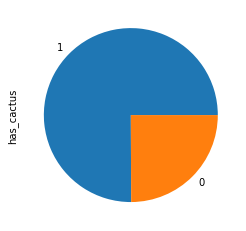

In [8]:
train_df['has_cactus'].value_counts().plot(kind='pie')

In [9]:
print("Test rows {0} and columns {1}".format(test_df.shape[0], test_df.shape[1]))

Test rows 4000 and columns 2


In [10]:
print("Train rows {0} and columns {1}".format(train_df.shape[0], train_df.shape[1]))

Train rows 17500 and columns 2


In [11]:
cacti = train_df[train_df.has_cactus==1].sample(n=3, random_state=42)
not_cacti = train_df[train_df.has_cactus==0].sample(n=3, random_state=42)

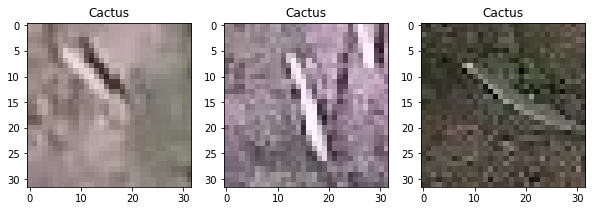

In [12]:
# plot for cactus images
fig = plt.figure(1, figsize=(10, 10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = pilimg.open(train_dir + cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Cactus')
    ax.imshow(arr)
plt.show()

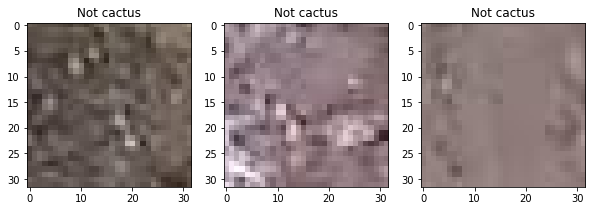

In [13]:
# plot for no cactus images
fig = plt.figure(1, figsize=(10, 10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = pilimg.open(train_dir + not_cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Not cactus')
    ax.imshow(arr, cmap='viridis')
plt.show()

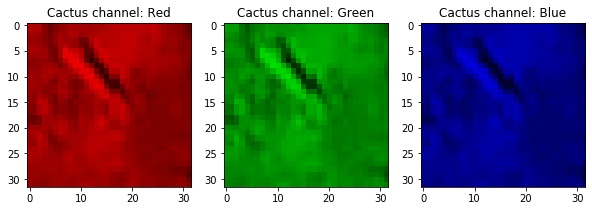

In [14]:
# plot of r, g, b channels of a cactus image
cactus_img = np.array(pilimg.open(train_dir + cacti.iloc[0, 0]))
fig = plt.figure(1, figsize=(10, 10))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    temp = np.zeros(cactus_img.shape, dtype='uint8')
    temp[:,:,i] = cactus_img[:,:,i]
    ax.imshow(temp)
    plt.title("Cactus channel: " + channels[i])
plt.show()

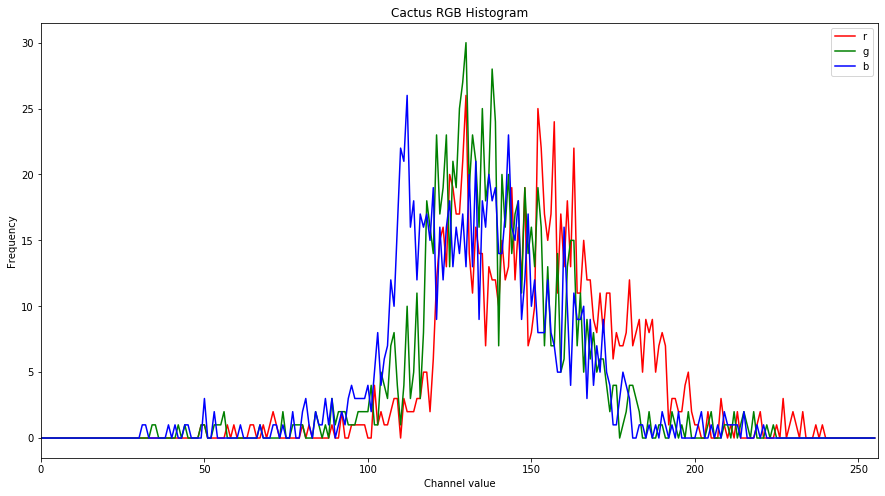

In [15]:
# plot of r, g, b channels histogram of a cactus image
colors = [('Red', 'r'), ('Green', 'g'), ('Blue', 'b')]
fig = plt.figure(figsize=(15, 8))
for i in range(3):
    hist = cv2.calcHist([cactus_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=colors[i][1], label=colors[i][1])
    plt.xlim([0, 256])
    plt.title("Cactus RGB Histogram")
    plt.xlabel("Channel value")
    plt.ylabel("Frequency")
    plt.legend()
plt.show()


In [16]:
train_df.has_cactus = train_df.has_cactus.astype(str)

In [17]:
# build a benchmark model to compare further refinements against
def benchmark_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [18]:
model = benchmark_model()
model.summary()

W0718 18:27:09.670340 13608 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:27:09.746296 13608 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:27:09.753291 13608 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 18:27:09.789272 13608 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

In [19]:
plot_model(model, to_file='samplemodel.png', show_shapes=True, show_layer_names=True)

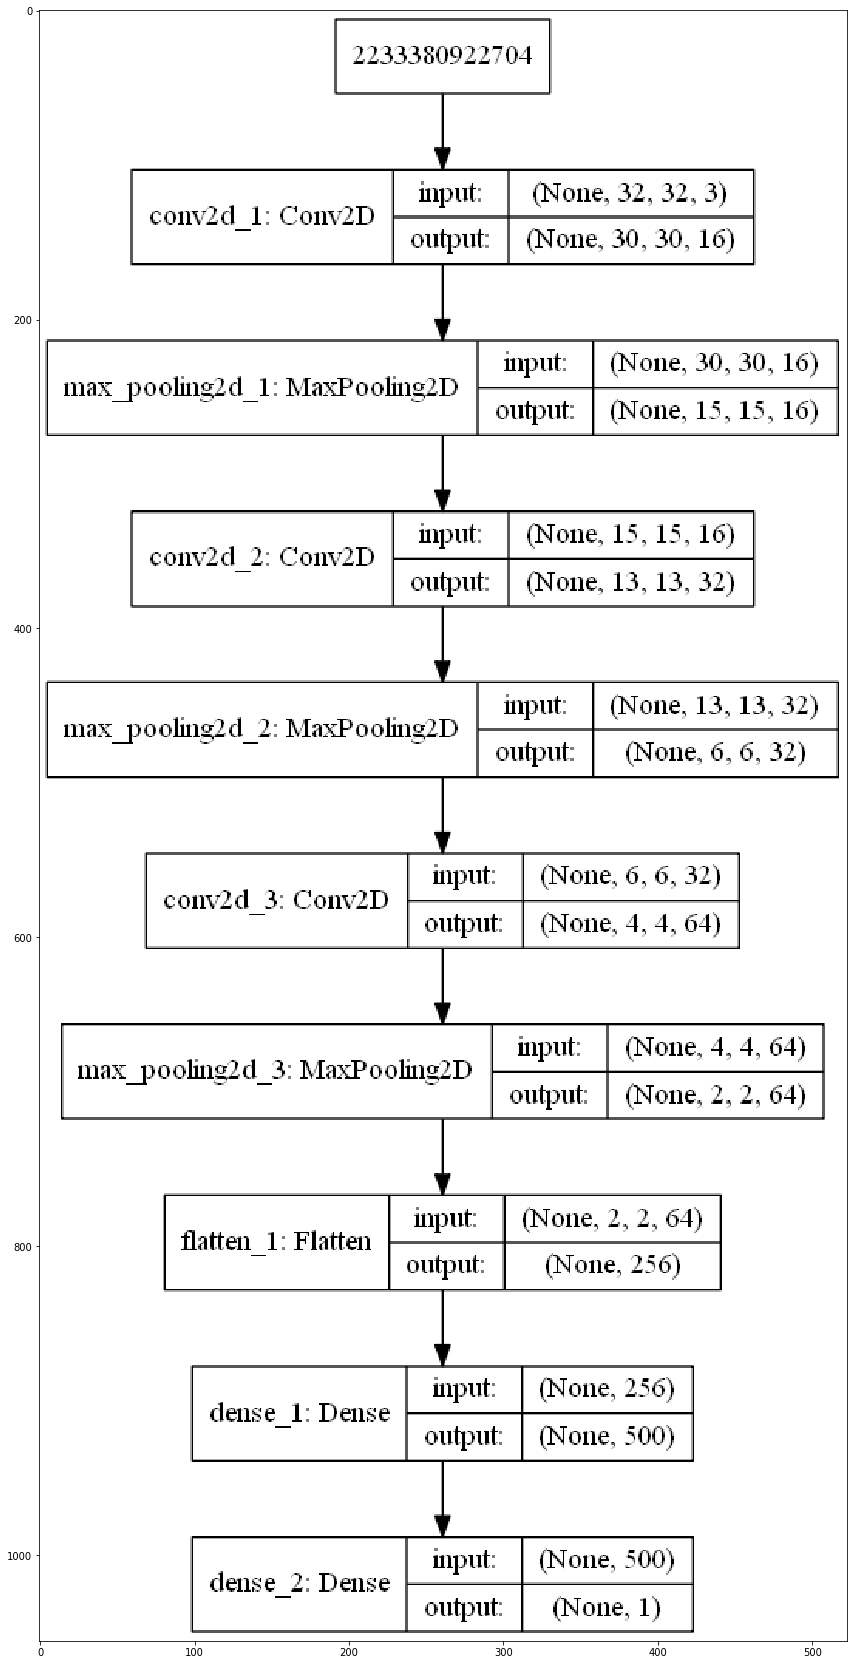

In [20]:
fig = plt.figure(figsize=(30, 30))
plt.imshow(pilimg.open('samplemodel.png'))
plt.show()

In [21]:
# plot of training and validation metrics
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy vs epochs')
    plt.ylabel('accuracy')
    plt.xlabel('no. of epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss vs epochs')
    plt.ylabel('loss')
    plt.xlabel('no. of epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
# get number of training and validation data from a 70-30 % split on original training data
def get_train_val_rows(train_df):
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_rows = train_df[:ind].shape[0] // 100
    val_rows = train_df[ind:].shape[0] // 50
    return train_rows, val_rows

In [23]:
# get training and validation generators to feed data in batch sizes to a model 
def get_train_valid_generators_with_scale(train_df, target_size=32, train_batch_size=100, val_batch_size=50):
    train_df = shuffle(train_df)
    gen = ImageDataGenerator(rescale=1./255)
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_gen = gen.flow_from_dataframe(dataframe=train_df[:ind],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=train_batch_size,
                                                target_size=(target_size,target_size), shuffle=False)


    val_gen = gen.flow_from_dataframe(dataframe=train_df[ind:],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=val_batch_size,
                                                    target_size=(target_size,target_size), shuffle=False)
    return train_gen, val_gen, ind


In [24]:
train_rows, val_rows = get_train_val_rows(train_df)

In [25]:
train_gen, val_gen, ind = get_train_valid_generators_with_scale(train_df)

Found 12250 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.


In [26]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = ModelCheckpoint(filepath='benchmark.best.hd5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history1 = model.fit_generator(train_gen, epochs=10, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights, callbacks=[callbacks])

Epoch 1/10
122/122 [==============================] - 13s 107ms/step - loss: 0.0653 - acc: 0.9759 - val_loss: 0.0522 - val_acc: 0.9817

Epoch 00001: val_loss improved from inf to 0.05219, saving model to benchmark.best.hd5
Epoch 2/10
122/122 [==============================] - 13s 103ms/step - loss: 0.0453 - acc: 0.9840 - val_loss: 0.1209 - val_acc: 0.9592

Epoch 00002: val_loss did not improve from 0.05219
Epoch 3/10
122/122 [==============================] - 13s 104ms/step - loss: 0.0521 - acc: 0.9809 - val_loss: 0.0453 - val_acc: 0.9846

Epoch 00003: val_loss improved from 0.05219 to 0.04528, saving model to benchmark.best.hd5
Epoch 4/10
122/122 [==============================] - 12s 95ms/step - loss: 0.0383 - acc: 0.9866 - val_loss: 0.0355 - val_acc: 0.9888

Epoch 00004: val_loss improved from 0.04528 to 0.03552, saving model to benchmark.best.hd5
Epoch 5/10
122/122 [==============================] - 12s 96ms/step - loss: 0.0303 - acc: 0.9904 - val_loss: 0.0385 - val_acc: 0.9870

Ep

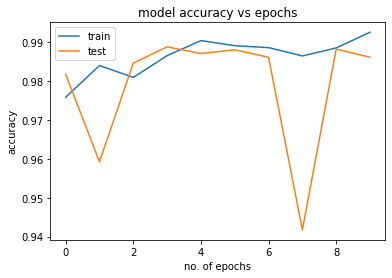

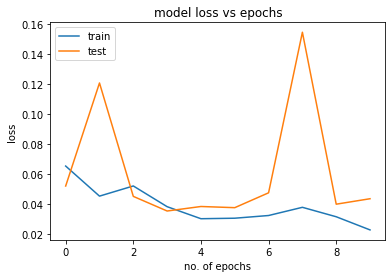

In [31]:
plot_history(history1)

In [34]:
# Benchmark model has training acc greater than test accuracy -> could mean overfitting, solution: dropout
refined_model = Sequential()
refined_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
refined_model.add(MaxPool2D(2, 2))
refined_model.add(Dropout(0.1))
refined_model.add(Conv2D(32, (3, 3), activation='relu'))
refined_model.add(Dropout(0.1))
refined_model.add(MaxPool2D(2, 2))
refined_model.add(Conv2D(64, (3, 3), activation='relu'))
refined_model.add(Dropout(0.1))
refined_model.add(MaxPool2D(2, 2))
refined_model.add(Flatten())
refined_model.add(Dense(500, activation='relu'))
refined_model.add(Dropout(0.1))
refined_model.add(Dense(1, activation='sigmoid'))
refined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [35]:
refined_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = ModelCheckpoint(filepath='refinement1.best.hd5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history2 = refined_model.fit_generator(train_gen, epochs=10, class_weight=class_weights, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, callbacks=[callbacks])

Epoch 1/10
122/122 [==============================] - 15s 121ms/step - loss: 0.3274 - acc: 0.8571 - val_loss: 0.1807 - val_acc: 0.9404

Epoch 00001: val_loss improved from inf to 0.18067, saving model to refinement1.best.hd5
Epoch 2/10
122/122 [==============================] - 13s 106ms/step - loss: 0.1448 - acc: 0.9463 - val_loss: 0.1449 - val_acc: 0.9453

Epoch 00002: val_loss improved from 0.18067 to 0.14487, saving model to refinement1.best.hd5
Epoch 3/10
122/122 [==============================] - 13s 106ms/step - loss: 0.1128 - acc: 0.9598 - val_loss: 0.2134 - val_acc: 0.9141

Epoch 00003: val_loss did not improve from 0.14487
Epoch 4/10
122/122 [==============================] - 13s 108ms/step - loss: 0.1027 - acc: 0.9617 - val_loss: 0.0949 - val_acc: 0.9657

Epoch 00004: val_loss improved from 0.14487 to 0.09491, saving model to refinement1.best.hd5
Epoch 5/10
122/122 [==============================] - 14s 114ms/step - loss: 0.0956 - acc: 0.9643 - val_loss: 0.0992 - val_acc: 0.

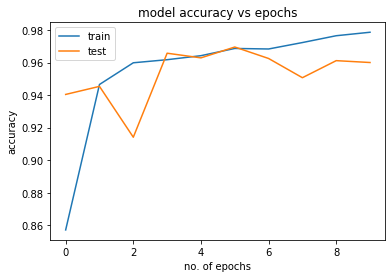

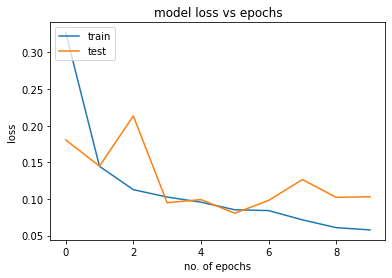

In [36]:
plot_history(history2)

In [37]:
def build_classifier(optimizer):
    m = Sequential()
    m.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    m.add(MaxPool2D(2, 2))
    m.add(Dropout(0.1))
    m.add(Conv2D(32, (3, 3), activation='relu'))
    m.add(Dropout(0.1))
    m.add(MaxPool2D(2, 2))
    m.add(Conv2D(64, (3, 3), activation='relu'))
    m.add(Dropout(0.1))
    m.add(MaxPool2D(2, 2))
    m.add(Flatten())
    m.add(Dense(500, activation='relu', kernel_initializer='random_uniform'))
    m.add(Dropout(0.1))
    m.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))
    m.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return m

In [38]:
train = []
ids = []
for f in os.listdir(train_dir):
    ids.append(f)
    path = os.path.join(train_dir, f)
    pil_arr = np.asarray(pilimg.open(path))
    train.append(pil_arr)
train = np.array(train)
train = train.astype('float32')
train_l = train_df['has_cactus']

In [39]:
gen1 = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rescale=1./255)
gen2 = ImageDataGenerator(zca_whitening=True, rescale=1./255)
gen3 = ImageDataGenerator(rotation_range=30, rescale=1./255)
gen4 = ImageDataGenerator(horizontal_flip=True, rescale=1./255)
gen5 = ImageDataGenerator(vertical_flip=True, rescale=1./255)
gen6 = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rescale=1./255)
gen7 = ImageDataGenerator(zoom_range=0.3, rescale=1./255)

c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [44]:
generators = [(gen1, 'center_std_norm'), (gen2, 'whitening'), (gen3, 'rotation:30'), (gen4, 'horizontal_flip'), (gen5, 'vertical_flip'), (gen6, 'shifts:0.2'), (gen7, 'zoom:0.3')]
def display_aug_effects():
    fig = plt.figure(1, figsize=(20, 15))
    for i, g in enumerate(generators):
        ax = fig.add_subplot(1, 7, i+1)        
        for X_batch, y_batch in g[0].flow(train, train_l, batch_size=10, seed=10, shuffle=False):
            plt.imshow(X_batch[9], cmap='viridis')
            plt.title(g[1])
            break
    plt.show()
        

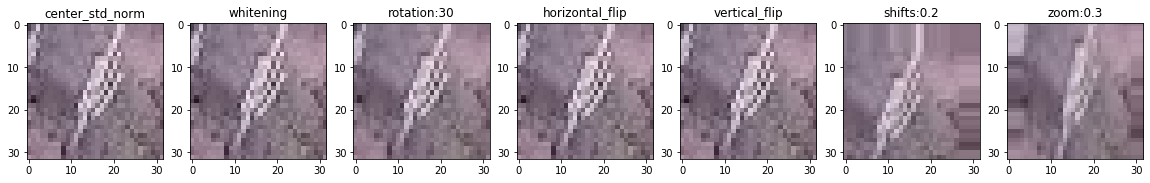

In [45]:
display_aug_effects()

In [46]:
aug_gen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rescale=1./255)

In [48]:
#k-fold stratified cross validation with Image Augmentation on the fly on the training dataset
n_splits = 5
val_preds = {i: [] for i in range(0, n_splits)}
val_labels = {}
train_preds = {i: [] for i in range(0, n_splits)}
train_labels = {}
history_log = {}
img_gen = ImageDataGenerator(rescale=1./255)
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10).split(train_df['id'], train_df['has_cactus']))
for i, (train_idx, valid_idx) in enumerate(splits):
    atrain_gen = aug_gen.flow_from_dataframe(dataframe=train_df.iloc[train_idx],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=100,
                                            target_size=(32, 32), shuffle=False)
    val_gen = img_gen.flow_from_dataframe(dataframe=train_df.iloc[valid_idx],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=50,
                                                    target_size=(32, 32), shuffle=False)
    
    train_rows = np.ceil(len(atrain_gen.classes)/100)
    val_rows = np.ceil(len(val_gen.classes)/50)
    train_labels[i] = atrain_gen.classes
    val_labels[i] = val_gen.classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(atrain_gen.classes), atrain_gen.classes)
    callbacks = ModelCheckpoint(filepath='model3_{0}.best.hd5'.format(i), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    clf = build_classifier('adam')
    history_log[i] = clf.fit_generator(atrain_gen, epochs=20,steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights, callbacks=[callbacks])
    clf.load_weights('model3_{0}.best.hd5'.format(i))
    atrain_gen.reset()
    val_gen.reset()
    train_preds[i].append(clf.predict_generator(atrain_gen, steps=train_rows))
    val_preds[i].append(clf.predict_generator(val_gen, steps=val_rows))

Found 13999 validated image filenames belonging to 2 classes.
Found 3501 validated image filenames belonging to 2 classes.
Epoch 1/20
140/140 [==============================] - 25s 179ms/step - loss: 0.3857 - acc: 0.8295 - val_loss: 0.2996 - val_acc: 0.8775

Epoch 00001: val_loss improved from inf to 0.29965, saving model to model3_0.best.hd5
Epoch 2/20
140/140 [==============================] - 23s 167ms/step - loss: 0.2340 - acc: 0.9088 - val_loss: 0.2323 - val_acc: 0.8992

Epoch 00002: val_loss improved from 0.29965 to 0.23230, saving model to model3_0.best.hd5
Epoch 3/20
140/140 [==============================] - 22s 161ms/step - loss: 0.2121 - acc: 0.9156 - val_loss: 0.1833 - val_acc: 0.9243

Epoch 00003: val_loss improved from 0.23230 to 0.18329, saving model to model3_0.best.hd5
Epoch 4/20
140/140 [==============================] - 23s 163ms/step - loss: 0.1947 - acc: 0.9268 - val_loss: 0.2204 - val_acc: 0.9075

Epoch 00004: val_loss did not improve from 0.18329
Epoch 5/20
140/1

140/140 [==============================] - 23s 161ms/step - loss: 0.0692 - acc: 0.9752 - val_loss: 0.0331 - val_acc: 0.9894

Epoch 00019: val_loss did not improve from 0.03236
Epoch 20/20
140/140 [==============================] - 22s 158ms/step - loss: 0.0668 - acc: 0.9761 - val_loss: 0.0458 - val_acc: 0.9811

Epoch 00020: val_loss did not improve from 0.03236
Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Epoch 1/20
140/140 [==============================] - 24s 168ms/step - loss: 0.3550 - acc: 0.8457 - val_loss: 0.2198 - val_acc: 0.9129

Epoch 00001: val_loss improved from inf to 0.21976, saving model to model3_2.best.hd5
Epoch 2/20
140/140 [==============================] - 22s 157ms/step - loss: 0.2158 - acc: 0.9164 - val_loss: 0.1721 - val_acc: 0.9291

Epoch 00002: val_loss improved from 0.21976 to 0.17209, saving model to model3_2.best.hd5
Epoch 3/20
140/140 [==============================] - 22s 159ms/s

140/140 [==============================] - 22s 154ms/step - loss: 0.0694 - acc: 0.9736 - val_loss: 0.0331 - val_acc: 0.9883

Epoch 00018: val_loss improved from 0.03536 to 0.03314, saving model to model3_3.best.hd5
Epoch 19/20
140/140 [==============================] - 22s 158ms/step - loss: 0.0703 - acc: 0.9749 - val_loss: 0.0442 - val_acc: 0.9820

Epoch 00019: val_loss did not improve from 0.03314
Epoch 20/20
140/140 [==============================] - 23s 161ms/step - loss: 0.0663 - acc: 0.9762 - val_loss: 0.0316 - val_acc: 0.9883

Epoch 00020: val_loss improved from 0.03314 to 0.03163, saving model to model3_3.best.hd5
Found 14001 validated image filenames belonging to 2 classes.
Found 3499 validated image filenames belonging to 2 classes.
Epoch 1/20
141/141 [==============================] - 25s 175ms/step - loss: 0.3610 - acc: 0.8479 - val_loss: 0.2985 - val_acc: 0.8768

Epoch 00001: val_loss improved from inf to 0.29847, saving model to model3_4.best.hd5
Epoch 2/20
141/141 [=====

In [49]:
# ROC curve plot
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
def plot_roc_curve(labels, preds):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(0, n_splits):
        pred_flat = np.array(preds[i]).flatten()
        fpr, tpr, thresholds = metrics.roc_curve(labels[i], pred_flat)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.title('AUC/ROC plot')
    plt.legend(loc="best")
    plt.show()

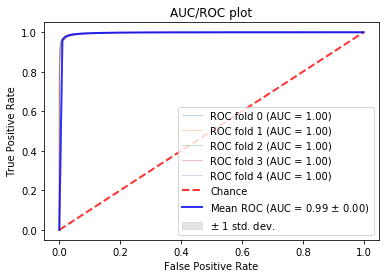

In [50]:
plot_roc_curve(train_labels, train_preds)

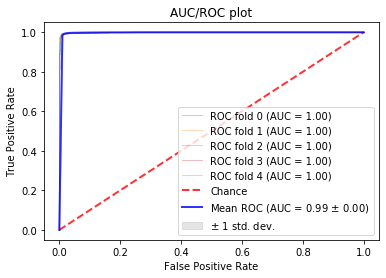

In [51]:
plot_roc_curve(val_labels, val_preds)

In [52]:
# plot for model accuracy vs no.of epochs across multiple folds
def plot_acc_history(hist):
    fig = plt.figure(1, figsize=(25, 5))
    for i in range(n_splits):
        ax = fig.add_subplot(1, 5, i+1)
        plt.plot(hist[i].history['acc'], label='acc')
        plt.plot(hist[i].history['val_acc'], label='val_acc')
        plt.title('model accuracy vs epochs: {0}th fold'.format(i+1))
        plt.ylabel('accuracy')
        plt.xlabel('no. of epochs')
        plt.legend(loc='best')
    plt.show()

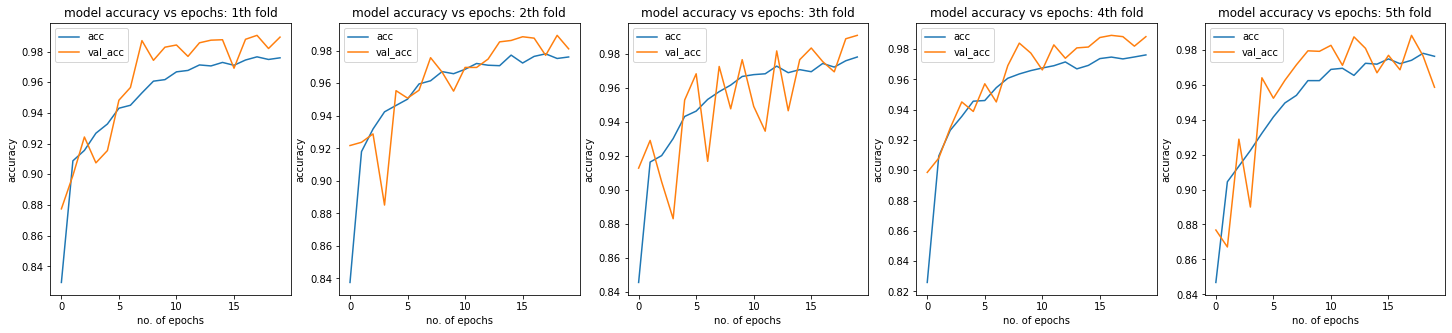

In [53]:
plot_acc_history(history_log)

In [54]:
# plot for model loss vs no.of epochs across multiple-folds 
def plot_model_loss(hist):
    fig = plt.figure(1, figsize=(25, 5))
    for i in range(n_splits):
        ax = fig.add_subplot(1, 5, i+1)
        plt.plot(hist[i].history['loss'], label='loss')
        plt.plot(hist[i].history['val_loss'], label='val_loss')
        plt.title('model loss vs epochs: {0}th fold'.format(i+1))
        plt.ylabel('loss')
        plt.xlabel('no. of epochs')
        plt.legend(loc='best')
    plt.show()

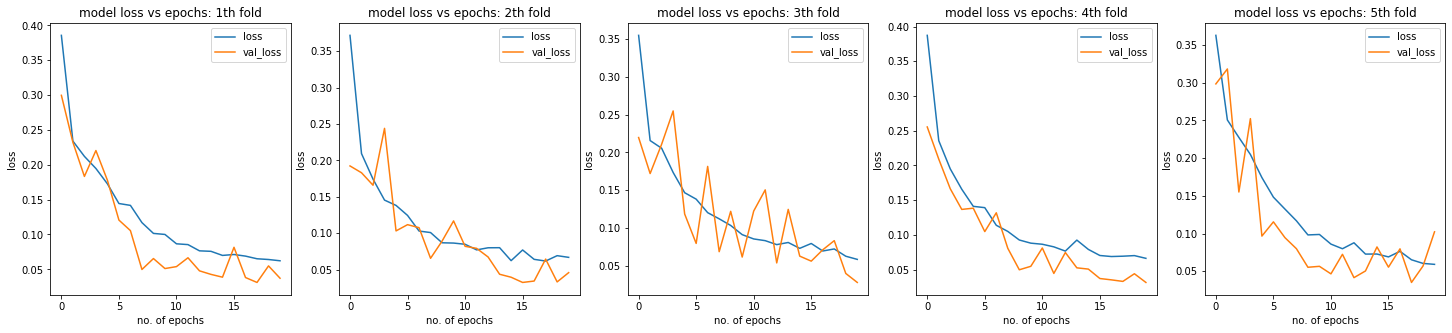

In [55]:
plot_model_loss(history_log)

In [56]:
# plot and observe the metrics values across several folds
def plot_metrics_over_fold(hist):
    met = ['acc', 'val_acc', 'loss', 'val_loss']
    inner_dict = {m: [] for m in met}
    results = {i: inner_dict for i in range(1, n_splits+1)}
    for i in range(1, n_splits+1):
        results[i]['acc'].append(np.mean(hist[i-1].history['acc']))
        results[i]['val_acc'].append(np.mean(hist[i-1].history['val_acc']))
        results[i]['loss'].append(np.mean(hist[i-1].history['loss']))
        results[i]['val_loss'].append(np.mean(hist[i-1].history['val_loss']))

    fig = plt.figure(1, figsize=(10, 5))  
    folds = [i for i in range(1, n_splits+1)]
    for i in range(1, n_splits+1):
        plt.plot(folds, results[i]['acc'], 'r--', label='acc' if i == 5 else '')
        plt.plot(folds, results[i]['val_acc'], 'b--', label='val_acc' if i == 5 else '')
        plt.plot(folds, results[i]['loss'], 'g--', label='loss' if i == 5 else '')
        plt.plot(folds, results[i]['val_loss'], 'm--', label='val_loss' if i == 5 else '')
        plt.title('metrics per fold')
        plt.ylabel('metrics')
        plt.xlabel('no. of folds')
    plt.legend(loc='best')
    plt.show()

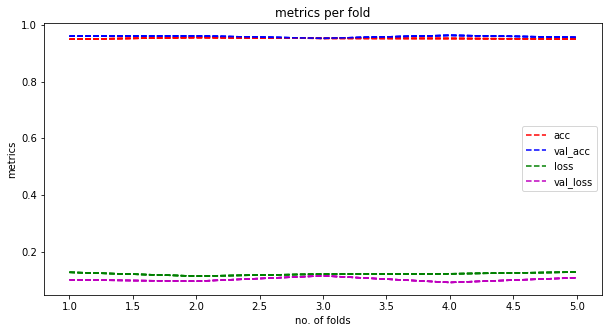

In [57]:
plot_metrics_over_fold(history_log)

In [58]:
# create a numpy array out of image data from test directory
x_test = []
ids = []
for f in os.listdir(test_dir):
    ids.append(f)
    path = os.path.join(test_dir, f)
    pil_arr = np.asarray(pilimg.open(path))
    x_test.append(pil_arr)
x_test = np.array(x_test)
print(x_test.shape)
x_test = x_test.astype('float32')/255

(3975, 32, 32, 3)


In [59]:
# get prediction probabilities for test data
clf1 = build_classifier('adam')
clf1.load_weights('model3_2.best.hd5')
predictions = clf1.predict_proba(x_test)

In [60]:
test_df = pd.DataFrame({'id': ids, 'has_cactus': predictions.flatten()})

In [61]:
# submission to kaggle
test_df.to_csv("samplesubmission.csv", index=False)

In [177]:
def plot_activations(df, clfx):
    layer_outputs = [layer.output for layer in clfx.layers[:6]] 
    activation_model = models.Model(inputs=clfx.input, outputs=layer_outputs)
    fig = plt.figure(figsize=(15, 10))
    it = 0
    for index, row in df.iterrows():
        ax = fig.add_subplot(1, 3, it+1)
        cactus_img = np.array(pilimg.open(train_dir + row['id']))/255.0
        img_tensor = np.expand_dims(cactus_img, axis=0)
        activations = activation_model.predict(img_tensor)
        ax.matshow(activations[0][0, :, :, 14], cmap='viridis')
        plt.title('{0}'.format(get_labels(row['has_cactus'])))
        it += 1
    plt.show()

(1, 30, 30, 16)
(1, 30, 30, 16)
(1, 30, 30, 16)


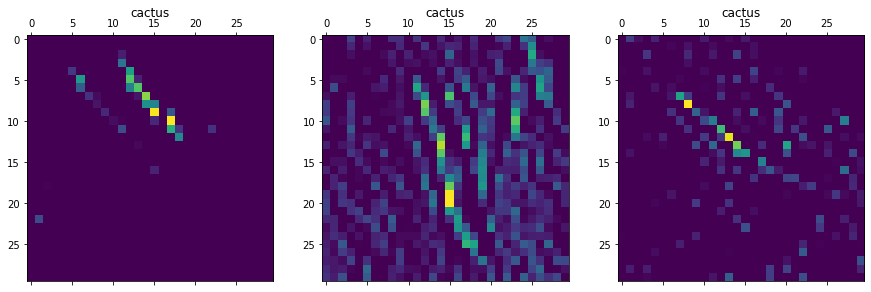

In [178]:
plot_activations(cacti, clf1)

(1, 30, 30, 16)
(1, 30, 30, 16)
(1, 30, 30, 16)


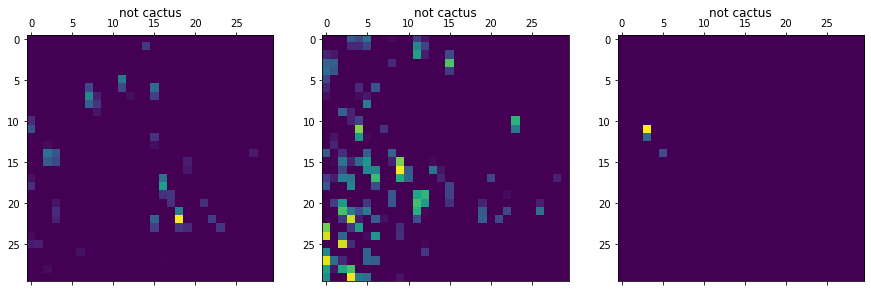

In [179]:
plot_activations(not_cacti, clf1)

In [62]:
# load a pre-trained vgg16 model for imagenet
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [63]:
# freeze the top layers i.e mark these layers' attribute trainable as false
for layer in vgg16.layers:
    layer.trainable = False

In [64]:
# combine the vgg16 pre-trained model with a custom network of three dense layers
def build_vgg_model():
    vgg_model = Sequential()
    vgg_model.add(vgg16)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(500, activation = 'relu'))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(300, activation = 'relu'))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(100, activation = 'relu'))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1, activation = 'sigmoid'))
    vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return vgg_model

In [65]:
vgg_model = build_vgg_model()
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_37 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               150300    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
__________

In [66]:
#k-fold stratified cross validation with Image Augmentation on the fly on the training dataset
n_splits_ = 5
vgg_val_preds = {i: [] for i in range(0, n_splits)}
vgg_val_labels = {}
vgg_train_preds = {i: [] for i in range(0, n_splits)}
vgg_train_labels = {}
vgg_history_log = {}
genvgg = ImageDataGenerator(rescale=1./255)
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10).split(train_df['id'], train_df['has_cactus']))
for i, (train_idx, valid_idx) in enumerate(splits):
    atrain_gen1 = aug_gen.flow_from_dataframe(dataframe=train_df.iloc[train_idx],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=100,
                                            target_size=(32, 32), shuffle=False)
    val_gen1 = genvgg.flow_from_dataframe(dataframe=train_df.iloc[valid_idx],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=50,
                                                    target_size=(32, 32), shuffle=False)
    
    train_rows = np.ceil(len(atrain_gen1.classes)/100)
    val_rows = np.ceil(len(val_gen1.classes)/50)
    vgg_train_labels[i] = atrain_gen1.classes
    vgg_val_labels[i] = val_gen1.classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(atrain_gen1.classes), atrain_gen1.classes)
    callbacks = ModelCheckpoint(filepath='model4_{0}.best.hd5'.format(i), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vgg_model = build_vgg_model()
    vgg_history_log[i] = vgg_model.fit_generator(atrain_gen1, epochs=20,steps_per_epoch=train_rows, validation_data=val_gen1, validation_steps=val_rows, class_weight=class_weights, callbacks=[callbacks])
    vgg_model.load_weights('model4_{0}.best.hd5'.format(i))
    atrain_gen1.reset()
    val_gen1.reset()
    vgg_train_preds[i].append(model.predict_generator(atrain_gen1, steps=train_rows))
    vgg_val_preds[i].append(model.predict_generator(val_gen1, steps=val_rows))



Found 13999 validated image filenames belonging to 2 classes.
Found 3501 validated image filenames belonging to 2 classes.
Epoch 1/20
140/140 [==============================] - 77s 553ms/step - loss: 0.3011 - acc: 0.8844 - val_loss: 0.1778 - val_acc: 0.9523

Epoch 00001: val_loss improved from inf to 0.17780, saving model to model4_0.best.hd5
Epoch 2/20
140/140 [==============================] - 74s 528ms/step - loss: 0.1729 - acc: 0.9419 - val_loss: 0.1457 - val_acc: 0.9477

Epoch 00002: val_loss improved from 0.17780 to 0.14570, saving model to model4_0.best.hd5
Epoch 3/20
140/140 [==============================] - 73s 523ms/step - loss: 0.1527 - acc: 0.9461 - val_loss: 0.1210 - val_acc: 0.9580

Epoch 00003: val_loss improved from 0.14570 to 0.12099, saving model to model4_0.best.hd5
Epoch 4/20
140/140 [==============================] - 73s 520ms/step - loss: 0.1424 - acc: 0.9499 - val_loss: 0.1104 - val_acc: 0.9629

Epoch 00004: val_loss improved from 0.12099 to 0.11039, saving mode

140/140 [==============================] - 75s 536ms/step - loss: 0.1074 - acc: 0.9595 - val_loss: 0.0641 - val_acc: 0.9749

Epoch 00019: val_loss did not improve from 0.05845
Epoch 20/20
140/140 [==============================] - 74s 529ms/step - loss: 0.1024 - acc: 0.9583 - val_loss: 0.0606 - val_acc: 0.9777

Epoch 00020: val_loss did not improve from 0.05845
Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.
Epoch 1/20
140/140 [==============================] - 79s 565ms/step - loss: 0.3044 - acc: 0.8832 - val_loss: 0.1119 - val_acc: 0.9640

Epoch 00001: val_loss improved from inf to 0.11190, saving model to model4_2.best.hd5
Epoch 2/20
140/140 [==============================] - 77s 549ms/step - loss: 0.1770 - acc: 0.9391 - val_loss: 0.1308 - val_acc: 0.9506

Epoch 00002: val_loss did not improve from 0.11190
Epoch 3/20
140/140 [==============================] - 76s 541ms/step - loss: 0.1495 - acc: 0.9459 - val_

140/140 [==============================] - 79s 567ms/step - loss: 0.1025 - acc: 0.9606 - val_loss: 0.1051 - val_acc: 0.9589

Epoch 00018: val_loss did not improve from 0.07547
Epoch 19/20
140/140 [==============================] - 72s 514ms/step - loss: 0.1070 - acc: 0.9596 - val_loss: 0.0763 - val_acc: 0.9726

Epoch 00019: val_loss did not improve from 0.07547
Epoch 20/20
140/140 [==============================] - 72s 511ms/step - loss: 0.1013 - acc: 0.9621 - val_loss: 0.1405 - val_acc: 0.9434

Epoch 00020: val_loss did not improve from 0.07547
Found 14001 validated image filenames belonging to 2 classes.
Found 3499 validated image filenames belonging to 2 classes.
Epoch 1/20
141/141 [==============================] - 77s 549ms/step - loss: 0.3054 - acc: 0.8891 - val_loss: 0.1357 - val_acc: 0.9580

Epoch 00001: val_loss improved from inf to 0.13566, saving model to model4_4.best.hd5
Epoch 2/20
141/141 [==============================] - 73s 519ms/step - loss: 0.1808 - acc: 0.9390 - val

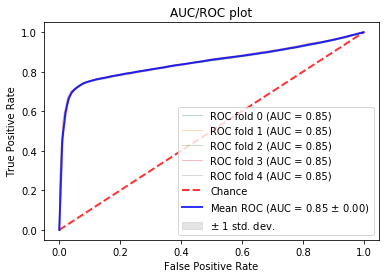

In [67]:
plot_roc_curve(vgg_train_labels, vgg_train_preds)

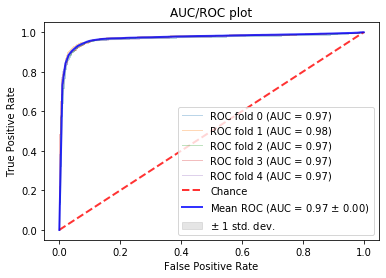

In [68]:
plot_roc_curve(vgg_val_labels, vgg_val_preds)

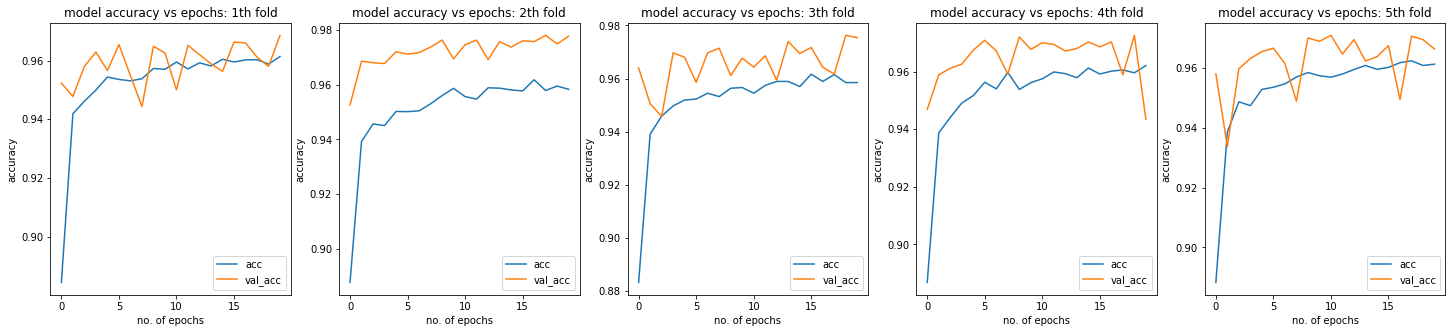

In [69]:
plot_acc_history(vgg_history_log)

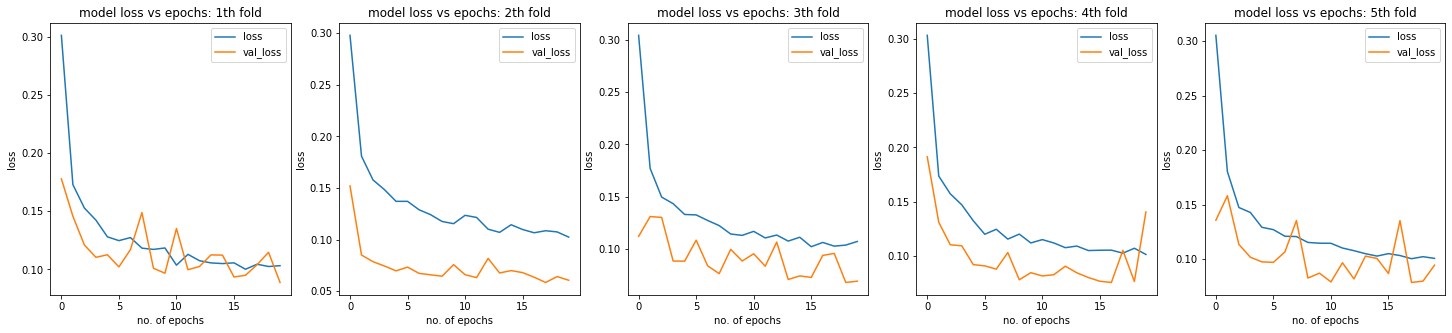

In [70]:
plot_model_loss(vgg_history_log)

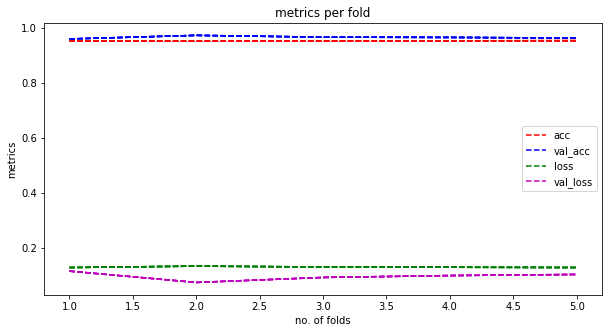

In [71]:
plot_metrics_over_fold(vgg_history_log)

In [75]:
def get_labels(cls):
    if cls == 1:
        return 'cactus'
    else:
        return 'not cactus'

In [76]:
vggmodel = build_vgg_model()

In [83]:
vggmodel.load_weights("model4_1.best.hd5")

In [142]:
vgg_predictions = vggmodel.predict_proba(x_test)
vgg_df = pd.DataFrame({'id': ids, 'has_cactus': vgg_predictions.flatten()})
vgg_df.to_csv("vggsubmission.csv", index=False)

In [85]:
def plot_true_pred_imgs(df, m):
    fig = plt.figure(figsize=(15, 10))
    it = 0
    for index, row in df.iterrows():
        ax = fig.add_subplot(1, 3, it+1)
        cactus_img = np.array(pilimg.open(train_dir + row['id']))
        img_tensor = np.expand_dims(cactus_img, axis=0)
        pred = m.predict_classes(img_tensor)
        plt.imshow(cactus_img)
        actual_pred = get_labels(row['has_cactus'])
        it += 1
        plt.title("pred: cactus, true label: {0}".format(actual_pred) if pred == 1 else "pred: not cactus, true label: {0}".format(actual_pred))
    plt.show()

In [112]:
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_19 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_55 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 300)               150300    
_________________________________________________________________
batch_normalization_20 (Batc (None, 300)               1200      
__________

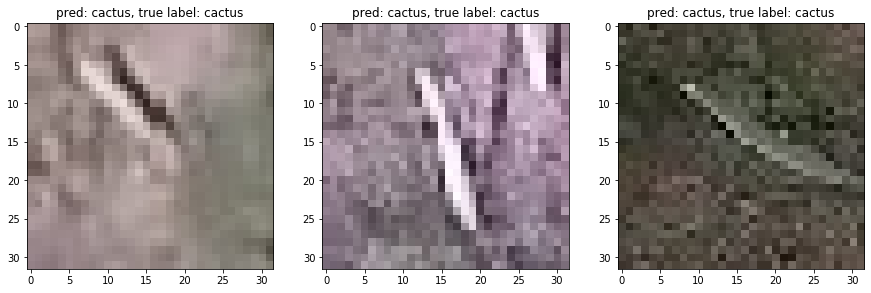

In [95]:
plot_true_pred_imgs(cacti, vggmodel)

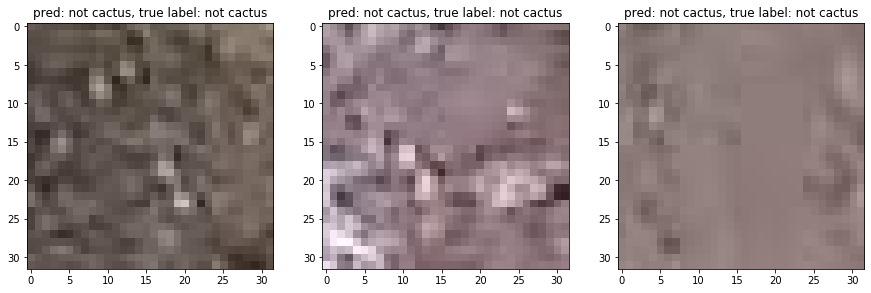

In [87]:
plot_true_pred_imgs(not_cacti, vggmodel)